In [ ]:
!pip install py-ecg-detectors mpld3 heartpy hrv-analysis ecg-plot

In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import *
from scipy import signal
import numpy as np
from ecgdetectors import Detectors
import tarfile
#from biosppy import storage
#from biosppy.signals import ecg
import mpld3
mpld3.enable_notebook()
import os, shutil
#import pywt
#import pywt.data
import matplotlib.patches as mpatches
import heartpy as hp
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
import tensorflow as tf
import ecg_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Setting path

In [ ]:
drive_path = '/content/drive/MyDrive/signal_data'
two_path = '/2/2.tar.gz'
CSPC_path = '/CPSC/CPSC.tar.gz'
E_path = '/E/E.tar.gz'
PTB_path = '/PTB/PTB.tar.gz'
PTB_XL_path = '/PTB-XL/PTB-XL.tar.gz'
StPetersburg_path = '/StPetersburg/StPetersburg.tar.gz'

In [ ]:
local_two_path = '2/Training_2/'
local_CSPC_path = 'CPSC/Training_WFDB/'
local_E_path = 'E/WFDB/'
local_PTB_path = 'PTB/WFDB/'
local_PTB_XL_path = 'PTB-XL/WFDB/'
local_StPetersburg_path = 'StPetersburg/WFDB/'

# Load data method

In [ ]:
def load_signal(path, file_name):
    if file_name.endswith('mat'):
        with open (path+file_name, 'rb') as file:
            return np.asarray(loadmat(file)['val'], dtype=np.float64)

In [ ]:
def load_signal_content(content):
  return np.asarray(loadmat(content)['val'], dtype=np.float64)

In [ ]:

def read_data(path):
    ls = os.listdir(path)
    record_name=list()
    mat = list()
    hea = list()
    count = 0
    for file in ls:
        if file.endswith('.mat'):
            count+=1
            mat.append(load_signal(path, file))
            record_name.append(file[:-4])
            header_file = file[:-3]+'hea'
            with open(path+header_file,'r') as f:
                hea.append(f.readlines())
            if count%1000==0:
                print('{count}/{total} done!!'.format(count=count, total = len(ls)/2))
    print('{count}/{total} done!!'.format(count=count, total = len(ls)/2))
    return mat, hea, record_name

In [ ]:
def extract_all_data(path, local_path):
  tar = tarfile.open(path, 'r:gz')
  tar.extractall(local_path)
  print("done")

## Load data

# Processing method

##Down sample + truncate

In [ ]:
def down_sample(data):
    resampled_data = list()
    
    for i in range(len(data)):
        resampled_leads = list()
        for j in range(len(data[i])):
            resampled_leads.append(resample(data[i][j], 5000))
        resampled_data.append(resampled_leads)
        
    
    return np.array(resampled_data)

In [ ]:
def truncate(lead):
    return lead[:5000]

In [ ]:
def truncate_to_5000(data, header,record_name):
    td = list()
    th = list()
    rd = list()
    
    for records, header,id in zip(data, header,record_name):
        if len(records[0])>=5000:
            td.append(records)
            th.append(header)
            rd.append(id)
    
    truncated_data = list()
    for i in range(len(td)):
        truncated_leads = list()
        for j in range(len(td[i])):
            truncated_leads.append(truncate(td[i][j]))
        truncated_data.append(truncated_leads)
        
    return truncated_data, th, rd

Memory problem

make 5000--> different window? and fit it into the model?

detect peak

use peak to 

can i cnn
then add more feature into the DNN?

removing outliers in rr intervals

data can't fit into one array


##remove + filter

In [ ]:
def remove_bw(data, sample_rate=500, cutoff=0.05):
    temp_data = list()
    count = 0
    for records in data:
        temp_records = list()
        for lead in records:
            temp_records.append(hp.remove_baseline_wander(lead,sample_rate=sample_rate,cutoff=cutoff))
        temp_data.append(temp_records)
        count+=1
        if count%1000==0:
            print('Remove baseline wander: ({count}/{total})'.format(count=count,total=len(data)))
    print('Remove baseline wander: ({count}/{total})'.format(count=count,total=len(data)))
    return np.array(temp_data)

In [ ]:
def filter(data):
    sos = butter(3,10, output='sos', btype='lowpass',fs=500)
    temp_data=list()
    count=0
    for records in data:
        temp_records = list()
        for lead in records:
            temp_records.append(sosfilt(sos,lead))
        temp_data.append(temp_records)
        count+=1
        if count%1000==0:
            print('Filter: ({count}/{total})'.format(count=count,total=len(data)))
    print('Filter: ({count}/{total})'.format(count=count,total=len(data)))
    return np.array(temp_data)


In [ ]:
def my_enhance_peaks(data):
    temp_data = []
    count=0
    for records in data:
        temp_records = []
        for lead in records:
            temp_records.append(hp.enhance_peaks(lead))
        temp_data.append(temp_records)
        count+=1
        if count%1000==0:
            print("Enhance peaks: ({count}/{total})".format(count=count, total=len(data)))
    print("Enhance peaks: ({count}/{total})".format(count=count,total=len(data)))
    return np.array(temp_data)

In [ ]:
def my_process_filter(data):
  return filter(data)

In [ ]:
def my_process(data):
    data = remove_bw(data)
    data = filter(data)
    #removed_data=[]
    
    data = my_enhance_peaks(data)
    #removed_filtered_data=[]

    return data



In [ ]:
def extract_wd(wd,m):
  #print(len(wd))
  features=[]
  #features.append(wd["RR_diff"][0])
  features.append(m["bpm"])
  features.append(m["breathingrate"])
  features.append(m["hr_mad"])
  features.append(m["ibi"])
  features.append(m["pnn20"])
  features.append(m["pnn50"])
  features.append(m["rmssd"])
  features.append(m["s"])
  features.append(m["sd1"])
  features.append(m["sd1/sd2"])
  features.append(m["sd2"])
  features.append(m["sdnn"])
  features.append(m["sdsd"])
  return np.array(features)

In [ ]:
def select_process(Xs_processed,Xs_filtered,ys,ids):
  count=0
  nan_count=0
  tempX=[]
  tempy=[]
  tempids=[]
  features = []
  for i in range(len(Xs_processed)):
    #print("next")
    try:
      wd,m = hp.process(Xs_processed[i][0],500)
      
    except hp.exceptions.BadSignalWarning as w:
      count+=1
      pass
    else:
      has_nan = False
      for value in m.values():
        if np.isnan(value):
          has_nan=True
      #print(has_nan)
      if has_nan:
        nan_count+=1
      else:
        #print("appending")
        features.append(extract_wd(wd,m))
        tempX.append(Xs_filtered[i])
        tempy.append(ys[i])
        tempids.append(ids[i])
  #print("nan count: "+str(nan_count))
  return tempX,tempy,tempids, features,count

In [ ]:
def extract_class(headers,X,id,X_filtered):
  all = np.array([
            270492004 , 
            164889003 , 
            164890007 ,
            426627000 , 
            713427006 , 
            713426002 , 
            445118002 ,
            39732003 ,
            164909002 ,
            251146004 , 
            698252002 ,
            10370003 ,
            284470004,
            427172004, 
            164947007 , 
            111975006 ,
            164917005 , 
            47665007 ,
            59118001 , 
            427393009 ,
            426177001,
            426783006 ,
            427084000 ,
            63593006 ,
            164934002 ,
            59931005 ,
            17338001])
  temp_ys = []
  temp_X_filtered=[]
  temp_X=[]
  temp_id=[]
  for i in range(len(headers)):
    ls = headers[i][15][5:].split(",")
    for j in range(len(ls)):
        ls[j]=int(ls[j])
    temp_y = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    found = False
    for value in ls:
      if value in all:
        found=True
      temp_y[np.where(all==value)]=1
    if found:
      temp_ys.append(temp_y)
      temp_X.append(X[i])
      temp_X_filtered.append(X_filtered[i])
      temp_id.append(id[i])
  return np.array(temp_ys), np.array(temp_X),np.array(temp_id),np.array(temp_X_filtered)

In [ ]:
extract_all_data(drive_path+two_path, "2/")
extract_all_data(drive_path+CSPC_path, "CPSC/")
extract_all_data(drive_path+E_path, "E/")
extract_all_data(drive_path+PTB_path, "PTB/")
extract_all_data(drive_path+PTB_XL_path, "PTB-XL/")
#extract_all_data(drive_path+StPetersburg_path, "StPetersburg/")

done
done
done
done
done


In [ ]:
for i in range(2,6):
  print(i)

In [ ]:
!rm -r PTB-XL

In [ ]:
import shutil
import os

ls = os.listdir("/content/PTB-XL/WFDB/")

count=0
for i in range(2,6):
  os.mkdir("/content/PTB-XL/WFDB_"+str(i)+"/")
  ls = os.listdir("/content/PTB-XL/WFDB/")
  count=0
  for file_name in ls:
    if file_name.endswith(".mat"):
      count+=1
      shutil.move("/content/PTB-XL/WFDB/"+file_name, "/content/PTB-XL/WFDB_"+str(i)+"/"+file_name)
      hea_file = file_name[:-3]+"hea"
      shutil.move("/content/PTB-XL/WFDB/"+hea_file, "/content/PTB-XL/WFDB_"+str(i)+"/"+hea_file)
      #print(count)
      if count==5000:
        print("?")
        break




?
?
?
?


In [ ]:

ls = os.listdir("PTB-XL/WFDB/")
print(len(ls))

ls = os.listdir("PTB-XL/WFDB_2/")
print(len(ls))
ls = os.listdir("PTB-XL/WFDB_3/")
print(len(ls))
ls = os.listdir("PTB-XL/WFDB_4/")
print(len(ls))
ls = os.listdir("PTB-XL/WFDB_5/")
print(len(ls))

3674
10000
10000
10000
10000


In [ ]:
import shutil
import os


shutil.make_archive("X", "zip", ".", "X")
shutil.make_archive("y","zip",".","y")
shutil.make_archive("labels_done","zip",".","labels_done")

'/content/labels_done.zip'

In [ ]:
shutil.move("/content/X.zip","/content/drive/MyDrive/signal_data")
shutil.move("/content/y.zip","/content/drive/MyDrive/signal_data")
shutil.move("/content/labels_done.zip","/content/drive/MyDrive/signal_data")

'/content/drive/MyDrive/signal_data/labels_done.zip'

In [ ]:
import shutil
import os
shutil.move("/content/Data.zip","/content/drive/MyDrive/signal_data")

'/content/drive/MyDrive/signal_data/Data.zip'

In [ ]:
data,hea= read_data("PTB-XL/WFDB/")
hhh = extract_class(hea)

1000/1837.0 done!!
1837/1837.0 done!!


In [ ]:
!mkdir X
!mkdir y
!mkdir Feature
!mkdir X_Processed

In [ ]:
paths=[local_two_path,local_CSPC_path,local_E_path,"PTB-XL/WFDB/","PTB-XL/WFDB_2/","PTB-XL/WFDB_3/","PTB-XL/WFDB_4/","PTB-XL/WFDB_5/"]
count=0

for j  in range(len(paths)):
  data,hea,record_name = read_data(paths[j])
  tru_data, tru_hea,tru_id = truncate_to_5000(data, hea,record_name)
  #print(len(tru_data))
  #print(len(tru_hea))
  #print(len(tru_id))
  data=[]
  hea=[]
  record_name=[]
  #print(data)
  split = int(len(tru_data)/2000)
  #print(split)
  if split==0:
    split=1
  splitted_data = np.array_split(np.array(tru_data),split,0)
  tru_data=[]
  splitted_hea = np.array_split(np.array(tru_hea), split,0)
  tru_hea=[]
  splitted_ID = np.array_split(np.array(tru_id),split,0)
  tru_id=[]
  for i in range(len(splitted_data)):
    #print(len(splitted_data[i][0][0]))

    Xs_processed = my_process(splitted_data[i])
    Xs_filtered = my_process_filter(splitted_data[i])
    IDs = splitted_ID[i]
    ys,Xs_processed,IDs,Xs_filtered = extract_class(splitted_hea[i],Xs_processed,IDs,Xs_filtered)
    print(len(Xs_processed))
    print(len(Xs_filtered))
    Xs,ys,IDs,features,temp_count = select_process(Xs_processed,Xs_filtered,ys,IDs)
    count+=temp_count
    for j in range(len(Xs)):
      #print(splitted_ID[j])
      np.save("X_Processed/"+IDs[j]+".npy",Xs_processed[j])
      np.save("X/"+IDs[j]+".npy",Xs[j])
      np.save("y/"+IDs[j]+"_label.npy",ys[j])
      np.save("Feature/"+IDs[j]+"_feature.npy",features[i])
      shutil.copyfile("labels_all/"+IDs[j]+".hea","labels/"+IDs[j]+".hea")
      
  splitted_data=[]
  splitted_hea=[]
  splitted_ID=[]
print(count)

In [ ]:

print(len(os.listdir("X/")))

33362


In [ ]:
count = 0
ls = os.listdir("Feature/")
for s in ls:
  temp = np.load("Feature/"+s)
  print(temp)


In [ ]:
paths=[local_two_path,local_CSPC_path,local_E_path,"PTB-XL/WFDB/","PTB-XL/WFDB_2/","PTB-XL/WFDB_3/","PTB-XL/WFDB_4/","PTB-XL/WFDB_5/"]

for path in paths:
  ls = os.listdir(path)
  for file_name in ls:
    if file_name.endswith(".hea"):
      #print("Data/"+file_name)
      shutil.copyfile(path+file_name,"/content/labels_all/"+file_name)

In [ ]:
print(len(os.listdir("/content/Feature/")))
print(len(os.listdir("/content/labels/")))
print(len(os.listdir("/content/X/")))
print(len(os.listdir("/content/y/")))

26726
0
26726
26726


In [ ]:
shutil.make_archive("X","zip",".","X")
shutil.make_archive("Feature","zip",".","Feature")
shutil.make_archive("y","zip",".","y")
shutil.make_archive("labels","zip",".","labels")

'/content/labels.zip'

In [ ]:
shutil.copyfile("Feature.zip","/content/drive/MyDrive/trial/Feature.zip")
shutil.copyfile("X.zip","/content/drive/MyDrive/trial/X.zip")
shutil.copyfile("y.zip","/content/drive/MyDrive/trial/y.zip")
shutil.copyfile("labels.zip","/content/drive/MyDrive/trial/labels.zip")

'/content/drive/MyDrive/trial/labels.zip'

In [ ]:
while True: pass

KeyboardInterrupt: ignored

# Test


In [ ]:
local_two_path

'2/Training_2/'

In [ ]:
data,hea,ids = read_data(local_two_path)

1000/3453.0 done!!
2000/3453.0 done!!
3000/3453.0 done!!
3453/3453.0 done!!


In [ ]:
len(data[0][0])

5000

In [ ]:
remove = remove_bw(data,500,0.05)

Remove baseline wander: (1000/3453)
Remove baseline wander: (2000/3453)
Remove baseline wander: (3000/3453)
Remove baseline wander: (3453/3453)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [ ]:
remove[0,0][0]

-2.6429895569050927

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data[1][0])
plt.savefig("Images/baseline1.png")

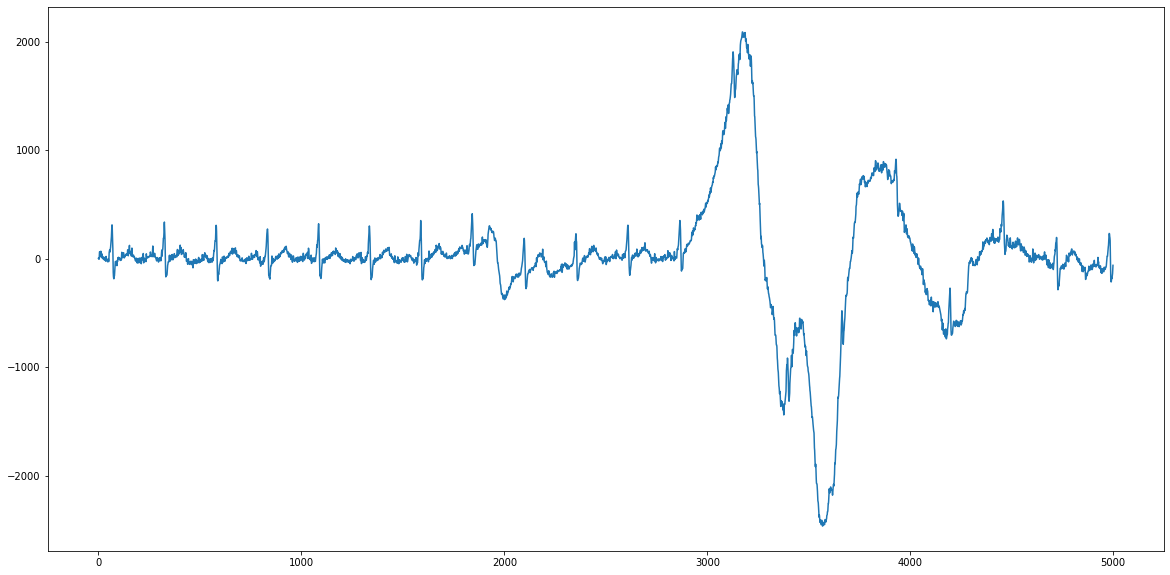

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data[1][0])
plt.savefig("Images/baseline1.png")

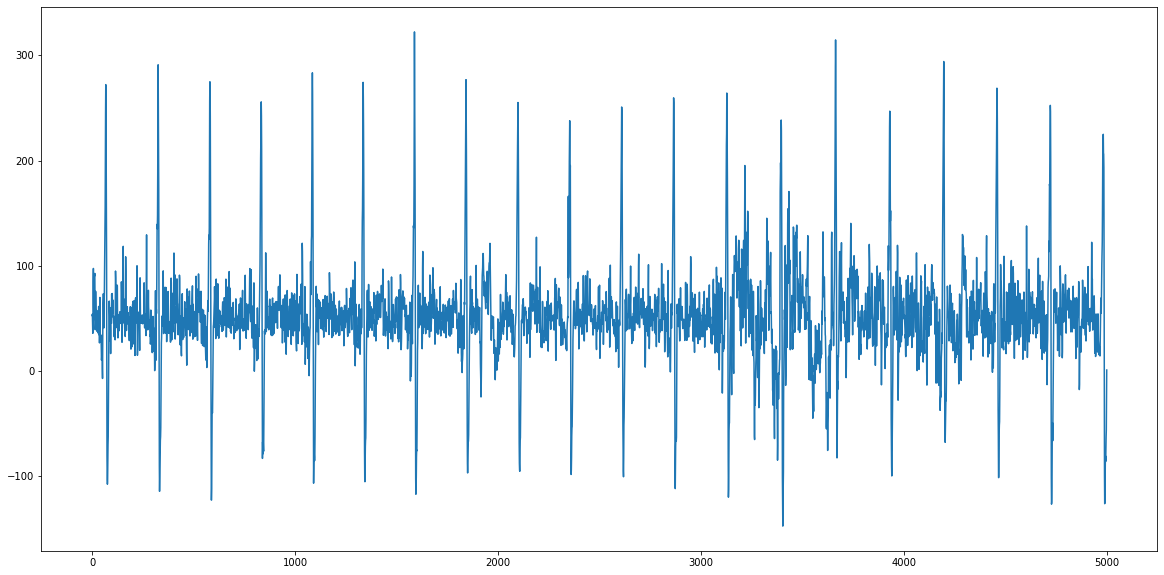

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(remove[1,0])
plt.savefig("Images/baseline2.png")

In [ ]:
filter = filter(remove)

Filter: (1000/3453)
Filter: (2000/3453)
Filter: (3000/3453)
Filter: (3453/3453)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


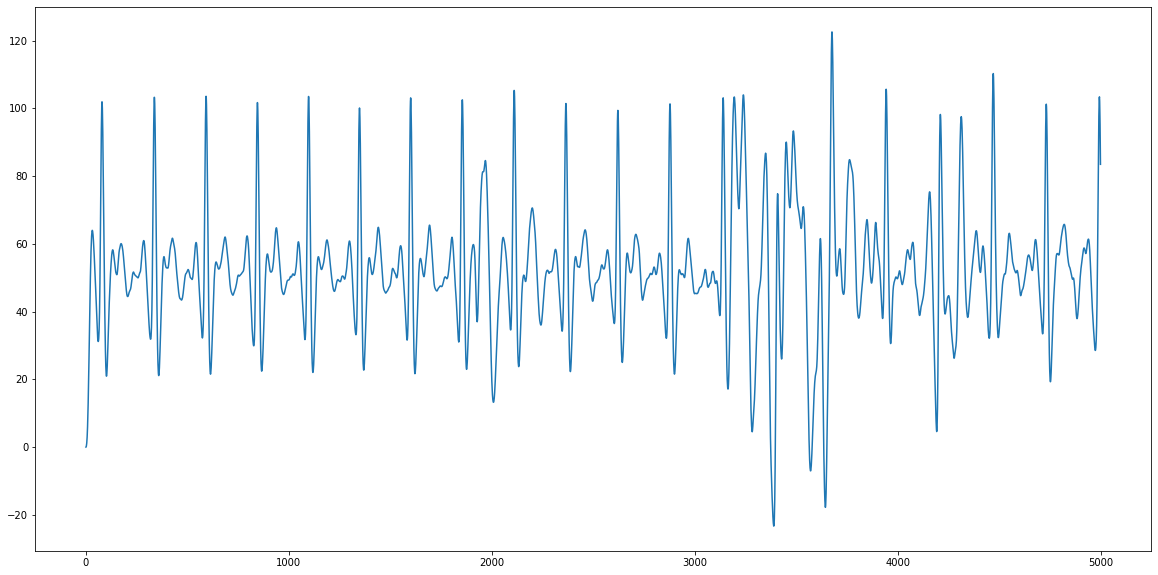

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(filter[1,0])
plt.savefig("Images/filter.png")

/usr/local/lib/python3.7/dist-packages/mpld3/mplexporter/exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


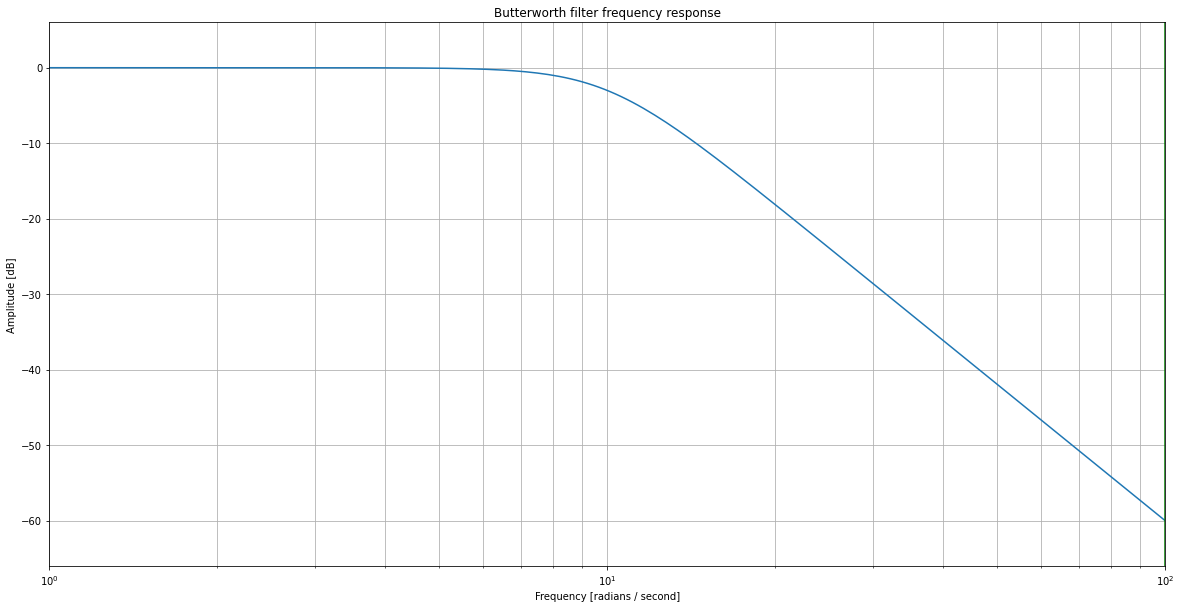

In [ ]:
b, a = butter(3, 10, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.figure(figsize=(20,10))
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency

plt.savefig("Images/order.png")
plt.show()

In [ ]:
enhance = my_enhance_peaks(filter)

Enhance peaks: (1000/3453)
Enhance peaks: (2000/3453)
Enhance peaks: (3000/3453)
Enhance peaks: (3453/3453)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


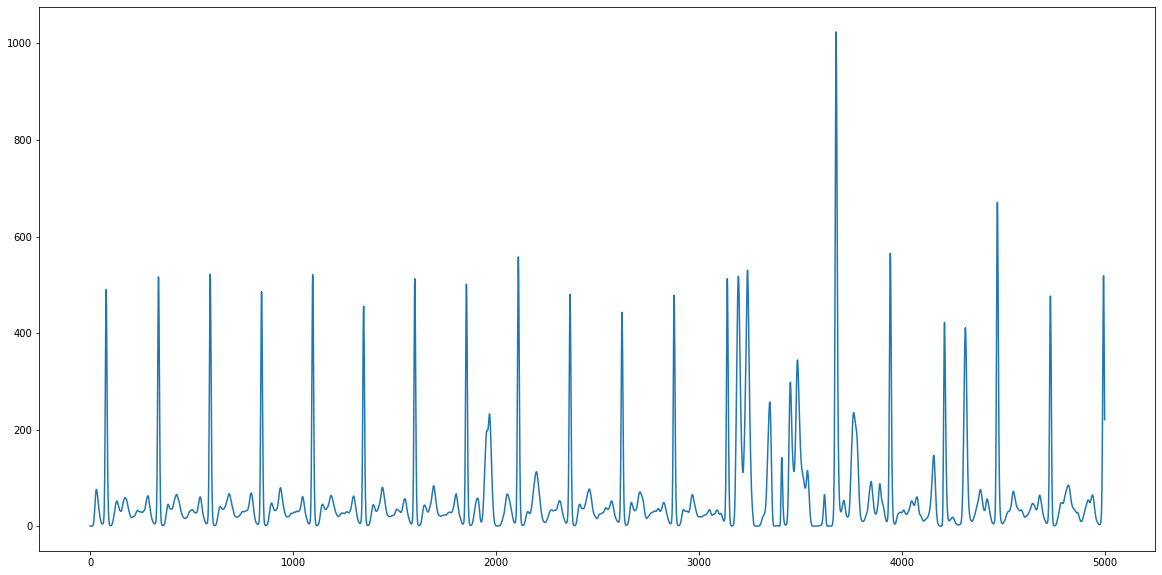

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(enhance[1,0])
plt.savefig("Images/enhance.png")

In [ ]:
del filter

NameError: ignored

In [ ]:
filter_only = filter(data)

Filter: (1000/3453)
Filter: (2000/3453)
Filter: (3000/3453)
Filter: (3453/3453)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


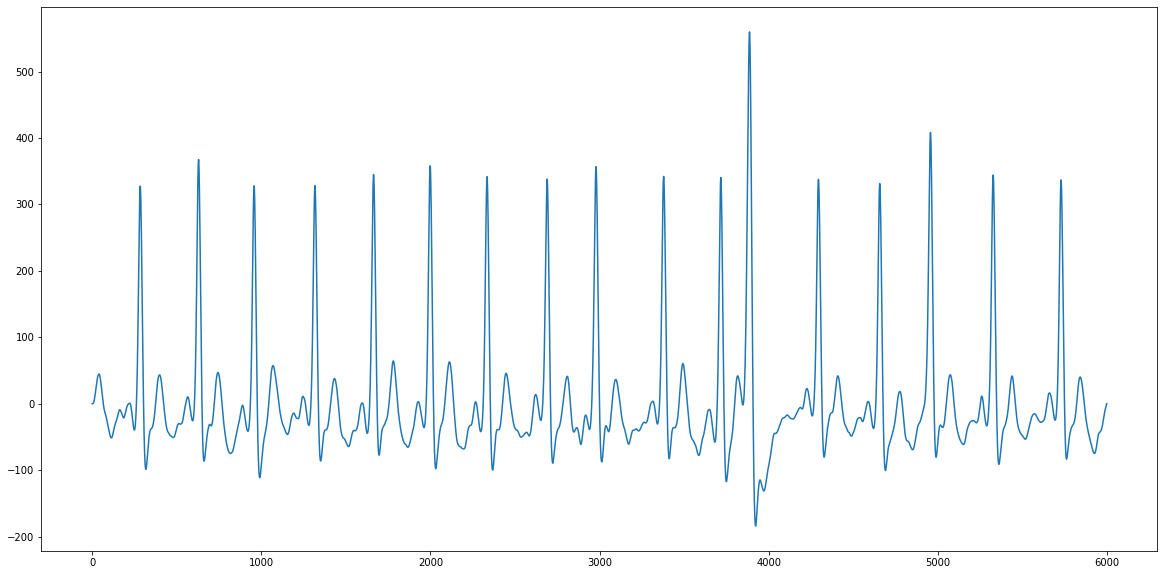

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(filter_only[8,0])
plt.savefig("filter_only.png")

In [ ]:
import shutil

In [ ]:
ls = os.listdir("Images/")
for s in ls:
  shutil.copyfile("Images/"+s,"/content/drive/MyDrive/Final_Year_Project/Dissertation/images/"+s)

In [ ]:
processed = my_process(data)

Remove baseline wander: (1000/5000)
Remove baseline wander: (2000/5000)
Remove baseline wander: (3000/5000)
Remove baseline wander: (4000/5000)
Remove baseline wander: (5000/5000)
Remove baseline wander: (5000/5000)
Filter: (1000/5000)
Filter: (2000/5000)
Filter: (3000/5000)
Filter: (4000/5000)
Filter: (5000/5000)
Filter: (5000/5000)
Enhance peaks: (1000/5000)
Enhance peaks: (2000/5000)
Enhance peaks: (3000/5000)
Enhance peaks: (4000/5000)
Enhance peaks: (5000/5000)
Enhance peaks: (5000/5000)


In [ ]:
print(len(processed))

5000


In [ ]:
wd,m = hp.process(processed[0][0],500)

In [ ]:
count=0
for leads in processed:
  try:
    wd,m = hp.process(leads[0],500)
  except hp.exceptions.BadSignalWarning as w:
    pass
  else:
    has_nan = False
    for value in m.values():
      if np.isnan(value):
        has_nan=True
    if has_nan:
      count+=1
    #print(m)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [ ]:
print(count)

905


In [ ]:
ls = os.listdir("PTB-XL/WFDB_2")
read_data

10000


In [ ]:
wd["RR_diff"][0]

14.0

In [ ]:
m


{'bpm': 1157.8947368421052,
 'breathingrate': 1.7543859649122806,
 'hr_mad': 0.0,
 'ibi': 51.81818181818182,
 'pnn20': 0.0,
 'pnn50': 0.0,
 'rmssd': 14.0,
 's': 0.0,
 'sd1': 0.0,
 'sd1/sd2': nan,
 'sd2': 0.0,
 'sdnn': 4.468438446343457,
 'sdsd': 0.0}

In [ ]:
wd


In [ ]:
m.keys()

dict_keys(['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate'])

In [ ]:
i=0
count=0
for leads in processed:
  i+=1

  try:
    hp.process(leads[0],500)
  except hp.exceptions.BadSignalWarning as w:
    count+=1
    print(str(i))
    pass
print("total: "+str(count))

In [ ]:
print(np.array(data_1).shape)

(3441, 12, 5000)


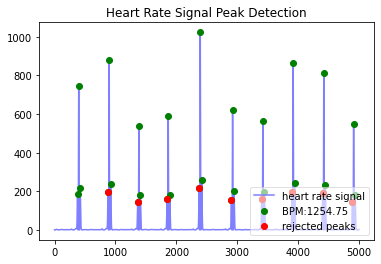

In [ ]:
patient = data_1[5]
lead = patient[1]
wd,mea = hp.process(lead,500)
hp.plotter(wd,mea)
#print(np.array(lead).shape)

5000


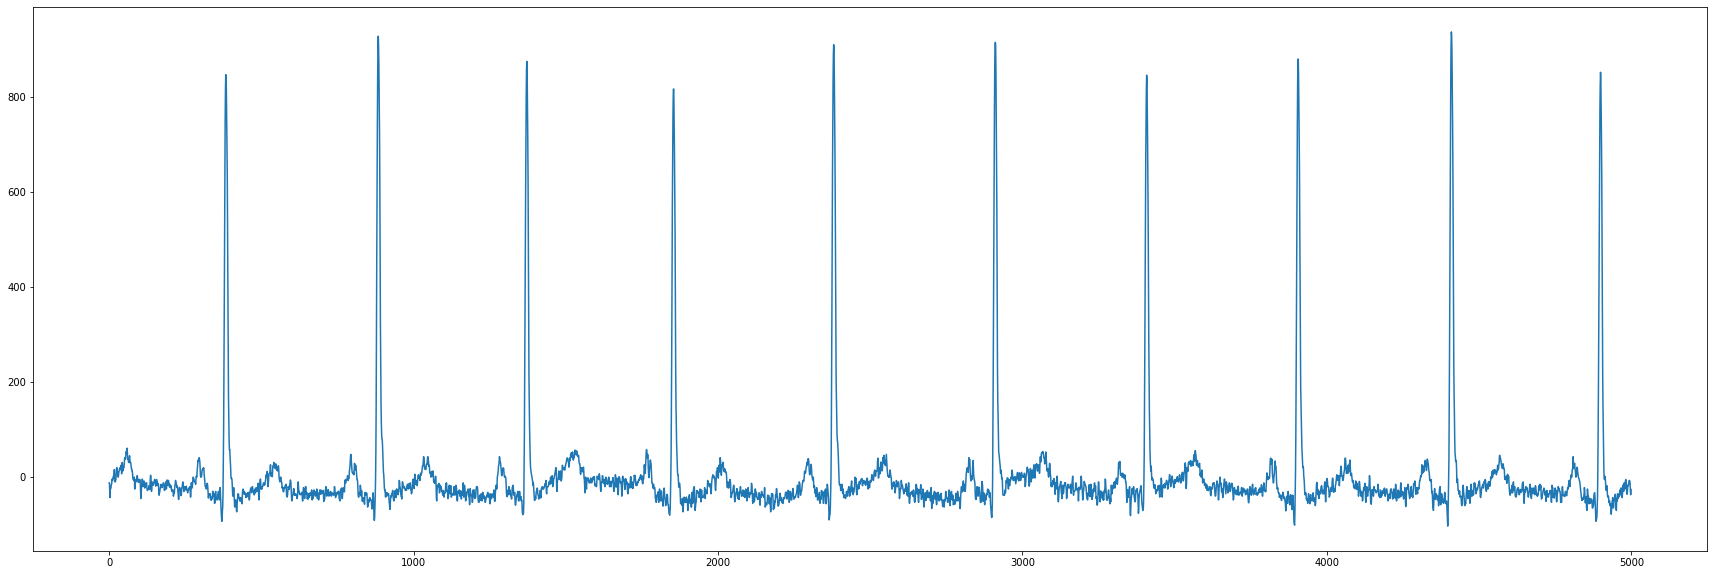

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(two_data[5][0])
print(len(tru_two_data[5][0]))

In [ ]:
for patient in data_1:
  for lead in patient:
    print(len(lead))
    try:
      hp.process(lead,500)
    except BadSignalWarning:
      print("Bad signal")

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(data_1[10][0])

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(tru_two_data[10][0])

CNN


In [ ]:
from sklearn.datasets import make_multilabel_classification
X,y = make_multilabel_classification(n_samples=3441, n_features = 5000, n_classes=24,n_labels=2,allow_unlabeled=True, )

In [ ]:
print(np.array(tru_two_data).shape)

(3441, 12, 5000)


In [ ]:
input_shape = (12,5000)
model = tf.keras.Sequential(layers=
                            [
                             tf.keras.layers.Conv1D(filters=64,kernel_size = 1, strides = 1, input_shape=input_shape),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.ReLU(),
                             tf.keras.layers.MaxPool1D(2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(27),
                             tf.keras.layers.Activation(tf.keras.activations.sigmoid)
                            ])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 12, 64)            320064    
_________________________________________________________________
batch_normalization_11 (Batc (None, 12, 64)            256       
_________________________________________________________________
re_lu_11 (ReLU)              (None, 12, 64)            0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 27)                10395     
_________________________________________________________________
activation_9 (Activation)    (None, 27)               

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_1, data_1_hea, test_size=0.20)


In [ ]:
history = model.fit(X_train, y_train, epochs = 10,validation_split = 0.2, verbose=1)

Epoch 1/10
69/69 [==============================] - 2s 15ms/step - loss: 0.6615 - val_loss: 0.5996
Epoch 2/10
69/69 [==============================] - 1s 11ms/step - loss: 0.5791 - val_loss: 0.5205
Epoch 3/10
69/69 [==============================] - 1s 11ms/step - loss: 0.5032 - val_loss: 0.4544
Epoch 4/10
69/69 [==============================] - 1s 11ms/step - loss: 0.4400 - val_loss: 0.3993
Epoch 5/10
69/69 [==============================] - 1s 11ms/step - loss: 0.3876 - val_loss: 0.3533
Epoch 6/10
69/69 [==============================] - 1s 11ms/step - loss: 0.3431 - val_loss: 0.3149
Epoch 7/10
69/69 [==============================] - 1s 11ms/step - loss: 0.3069 - val_loss: 0.2828
Epoch 8/10
69/69 [==============================] - 1s 11ms/step - loss: 0.2759 - val_loss: 0.2558
Epoch 9/10
69/69 [==============================] - 1s 11ms/step - loss: 0.2515 - val_loss: 0.2330
Epoch 10/10
69/69 [==============================] - 1s 10ms/step - loss: 0.2279 - val_loss: 0.2137


In [ ]:
results  = model.evaluate(X_test,y_test)
print(results)

22/22 [==============================] - 0s 6ms/step - loss: 0.2126
0.21255521476268768


In [ ]:
while True: pass

In [ ]:
def get_diag(predict_y,actual_y):
  all = np.array([
          "1st degree AV block" , 
          "Atrial Fibrillation" , 
          "Atrial flutter" ,
          "Bradycardia" , 
          "Complete right bundle branch block" , 
          "Incomplete right bundle branch block" , 
          "Left anterior fascicular block" ,
          "Left axis deviation" ,
          "Left bundle branch block" ,
          "Low QRS voltages"  , 
          "Nonspecific intraventricular conduction disorder" ,
          "Pacing rhythm" ,
          "Premature atrial contraction",
          "Premature ventricular contractions", 
          "Prolonged PR interval" , 
          "Prolonged QT interval" ,
          "Q wave abnormal" , 
          "Right axis deviation" ,
          "Right bundle branch block" , 
          "Sinus arrhythmia" ,
          "Sinus bradycardia",
          "Sinus rhythm" ,
          "Sinus tachycardia" ,
          "Supraventricular premature beats" ,
          "T wave abnormal" ,
          "T wave inversion"  ,
          "Ventricular premature beats"])
  pdia=[]
  adia=[]
  #print(predict_y)
  for i in range(len(predict_y)):
    if predict_y[i]>0.4:
      predict_y[i]=1
    else:
      predict_y[i]=0
  #print(predict_y)
  #print(actual_y)
  for i in range(len(actual_y)):
    if actual_y[i]==1:
      adia.append(all[i])
  for i in range(len(predict_y)):
    if predict_y[i]==1:
      pdia.append(all[i])
  return pdia,adia

In [ ]:
data, head, record_name = read_data("CPSC/Training_WFDB/")
tru_data, tru_hea, tru_id = truncate_to_5000(data,head,record_name)
X_processed = my_process(tru_data)
X_filtered = my_process_filter(tru_data)
IDs = tru_id
y,X_processed,IDs,X_filtered=extract_class(tru_hea,X_processed,IDs,X_filtered)
X,y,IDs,features,temp_count = select_process(X_processed,X_filtered,y,IDs)



In [ ]:
print(np.array(X).shape)
print(np.array(y).shape)
print(np.array(IDs).shape)
print(np.array(features).shape)
print(np.array(temp_count).shape)
n = len(X)
print(n)
print(len(X[0]))

(3810, 12, 5000)
(3810, 27)
(3810,)
(3810, 13)
()
3810
12


In [ ]:
import tensorflow as tf
import random
model = tf.keras.models.load_model("/content/drive/MyDrive/signal_data/final_model/model")


In [ ]:
i = random.randint(0,n)
count=0
for i in range(len(X)):
  signal = np.array(X)[i][None,...]
  actual_y = y[i]
  predict_y = model.predict(signal)[0]
  pre, ac = get_diag(predict_y,actual_y)
  print(pre,ac)
  if any(x in ac for x in pre):
    print(pre,ac)
    count+=1
print(count)

[] ['1st degree AV block']
['Sinus rhythm'] ['Atrial Fibrillation']
['Pacing rhythm'] ['Sinus rhythm']
[] ['Atrial Fibrillation']
['Sinus rhythm'] ['Atrial Fibrillation', 'Right bundle branch block']
[] ['Premature atrial contraction']
['Atrial Fibrillation', 'Complete right bundle branch block', 'Left bundle branch block', 'Nonspecific intraventricular conduction disorder', 'Premature ventricular contractions', 'Right bundle branch block', 'Sinus tachycardia', 'Ventricular premature beats'] ['1st degree AV block']
[] ['Sinus rhythm']
['Sinus rhythm'] ['Atrial Fibrillation']
[] ['Sinus rhythm']
[] ['Right bundle branch block']
['Left bundle branch block', 'Premature ventricular contractions', 'Sinus tachycardia'] ['1st degree AV block']
['Pacing rhythm', 'Right bundle branch block'] ['Sinus rhythm']
[] ['Right bundle branch block']
[] ['1st degree AV block']
[] ['Right bundle branch block']
['Sinus rhythm'] ['Atrial Fibrillation']
[] ['Premature atrial contraction']
['Sinus rhythm'] ['